<a href="https://colab.research.google.com/github/natalfr17/An-lise-Estat-stica-de-Dados-e-Informa-es/blob/main/Tarefa_5_parte1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Modelo preditivo usando Regressão Logística**

Inicialmente será construído um modelo de regressão logística para retenção de clientes usando a técnica "SMOTE" para balanceamento de classes e RFE para seleção das variáveis.

Na sequência será refeito o modelo, no entanto, para balanceamento da classes, serão eliminados, de forma aleatória, a classe com maior quantidade e, desta forma, se igualando a classe com menor quantidade.

Ao final, ambos os resultados serão comparados.

In [2]:
# Importar bibliotecas

import pandas as pd
import numpy as np
from sklearn import preprocessing
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
import seaborn as sns
sns.set(style="white")
sns.set(style="whitegrid", color_codes=True)

In [3]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("adammaus/predicting-churn-for-bank-customers")

print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/predicting-churn-for-bank-customers


In [4]:
# Ler base

df = pd.read_csv(path + "/Churn_Modelling.csv")
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   RowNumber        10000 non-null  int64  
 1   CustomerId       10000 non-null  int64  
 2   Surname          10000 non-null  object 
 3   CreditScore      10000 non-null  int64  
 4   Geography        10000 non-null  object 
 5   Gender           10000 non-null  object 
 6   Age              10000 non-null  int64  
 7   Tenure           10000 non-null  int64  
 8   Balance          10000 non-null  float64
 9   NumOfProducts    10000 non-null  int64  
 10  HasCrCard        10000 non-null  int64  
 11  IsActiveMember   10000 non-null  int64  
 12  EstimatedSalary  10000 non-null  float64
 13  Exited           10000 non-null  int64  
dtypes: float64(2), int64(9), object(3)
memory usage: 1.1+ MB


In [5]:
df.describe()

,RowNumber,CustomerId,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
count,10000.00000,1.000000e+04,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.00000,10000.000000,10000.000000,10000.000000
mean,5000.50000,1.569094e+07,650.528800,38.921800,5.012800,76485.889288,1.530200,0.70550,0.515100,100090.239881,0.203700
std,2886.89568,7.193619e+04,96.653299,10.487806,2.892174,62397.405202,0.581654,0.45584,0.499797,57510.492818,0.402769
min,1.00000,1.556570e+07,350.000000,18.000000,0.000000,0.000000,1.000000,0.00000,0.000000,11.580000,0.000000
25%,2500.75000,1.562853e+07,584.000000,32.000000,3.000000,0.000000,1.000000,0.00000,0.000000,51002.110000,0.000000
50%,5000.50000,1.569074e+07,652.000000,37.000000,5.000000,97198.540000,1.000000,1.00000,1.000000,100193.915000,0.000000
75%,7500.25000,1.575323e+07,718.000000,44.000000,7.000000,127644.240000,2.000000,1.00000,1.000000,149388.247500,0.000000
max,10000.00000,1.581569e+07,850.000000,92.000000,10.000000,250898.090000,4.000000,1.00000,1.000000,199992.480000,1.000000


In [6]:
# Checar valores nulos

df.isnull().sum()

,0
RowNumber,0
CustomerId,0
Surname,0
CreditScore,0
Geography,0
Gender,0
Age,0
Tenure,0
Balance,0
NumOfProducts,0


In [7]:
#manter apenas variáveis de interesse

df = df.drop(['RowNumber', 'CustomerId', 'Surname'], axis=1)
df

,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0
...,...,...,...,...,...,...,...,...,...,...,...
9995,771,France,Male,39,5,0.00,2,1,0,96270.64,0
9996,516,France,Male,35,10,57369.61,1,1,1,101699.77,0
9997,709,France,Female,36,7,0.00,1,0,1,42085.58,1
9998,772,Germany,Male,42,3,75075.31,2,1,0,92888.52,1


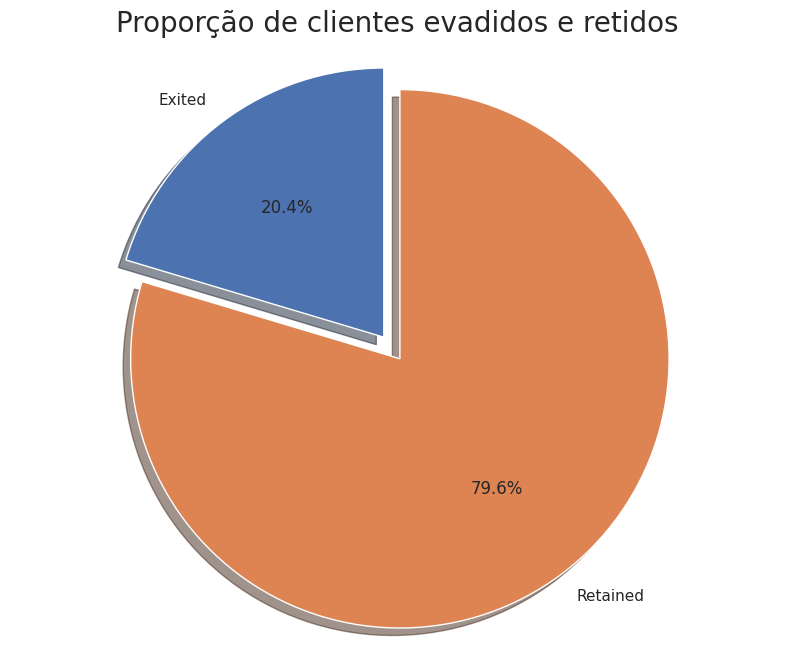

2037 7963


In [8]:
# Entender a proporção da base

labels = 'Exited', 'Retained'
sizes = [df.Exited[df['Exited']==1].count(), df.Exited[df['Exited']==0].count()]
explode = (0, 0.1)
fig1, ax1 = plt.subplots(figsize=(10, 8))
ax1.pie(sizes, explode=explode, labels=labels, autopct='%1.1f%%',
        shadow=True, startangle=90)
ax1.axis('equal')
plt.title("Proporção de clientes evadidos e retidos", size = 20)
plt.show()

print(df.Exited[df['Exited']==1].count(), df.Exited[df['Exited']==0].count())

<Axes: xlabel='IsActiveMember', ylabel='count'>

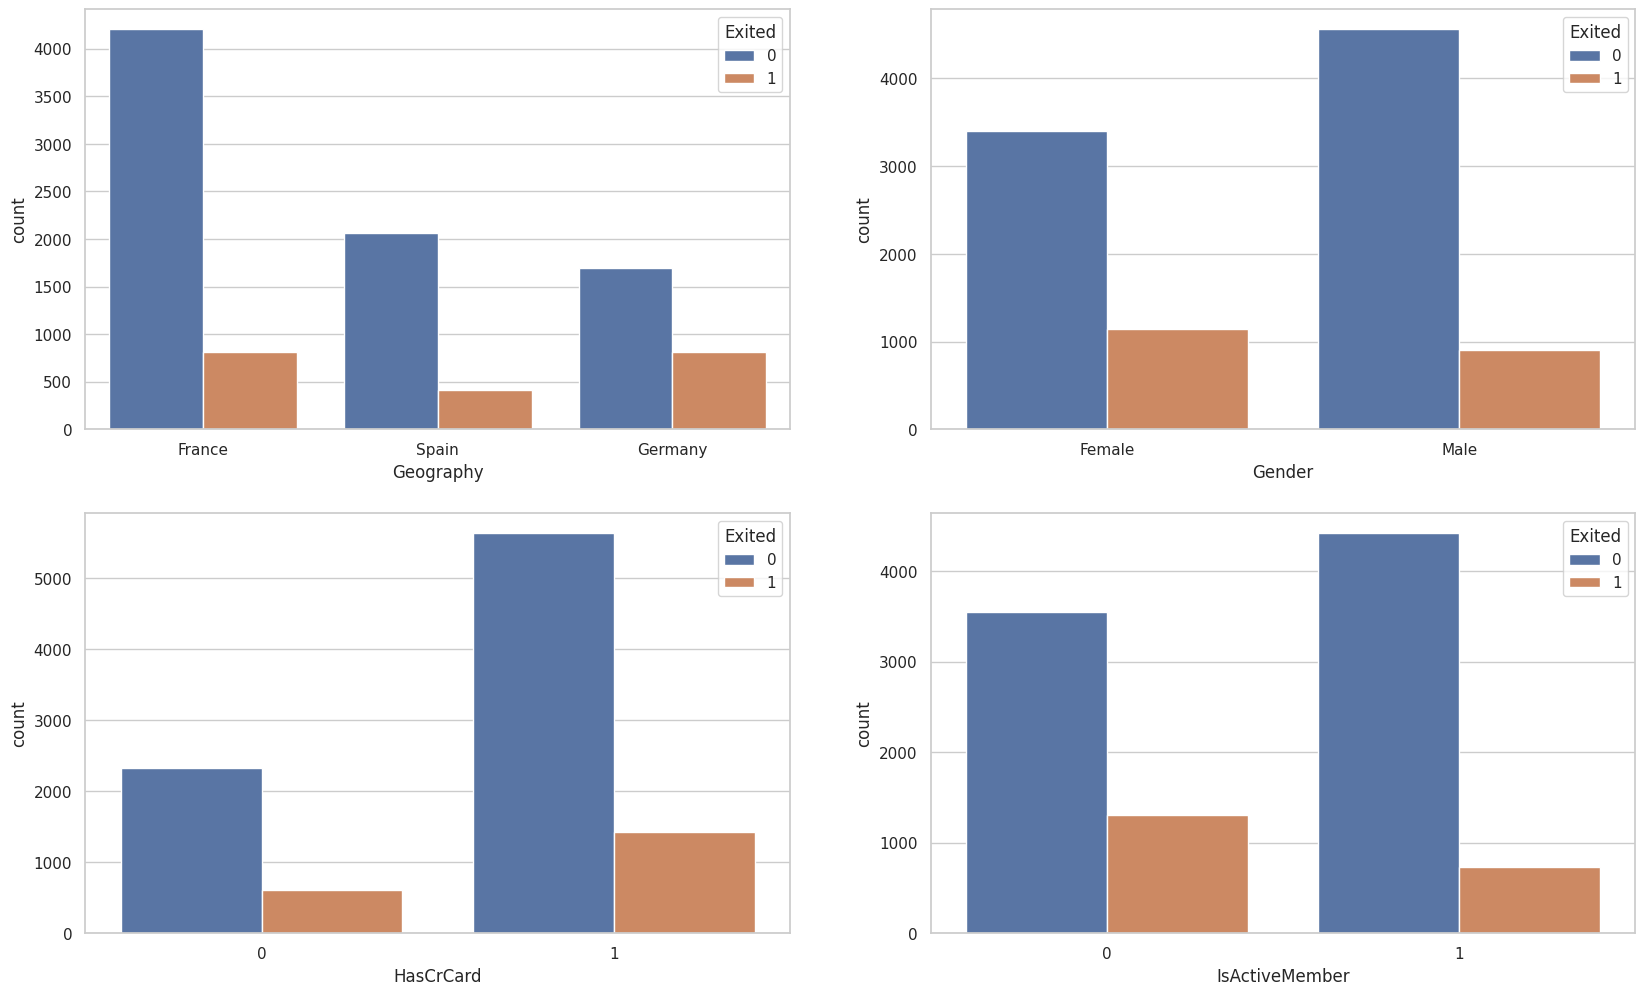

In [9]:
# Analisar a relação entra as variáveis catgóricas e a variável de saída "Exited"
fig, axarr = plt.subplots(2, 2, figsize=(20, 12))
sns.countplot(x='Geography', hue = 'Exited',data = df, ax=axarr[0][0])
sns.countplot(x='Gender', hue = 'Exited',data = df, ax=axarr[0][1])
sns.countplot(x='HasCrCard', hue = 'Exited',data = df, ax=axarr[1][0])
sns.countplot(x='IsActiveMember', hue = 'Exited',data = df, ax=axarr[1][1])

In [10]:
# Agrupa os dados pela variável 'Exited' (0 = permaneceu, 1 = saiu do banco)
# Calcula a média de todas as variáveis numéricas para cada grupo

df.groupby('Exited').mean(numeric_only=True)

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary
Exited,,,,,,,,
0,651.853196,37.408389,5.033279,72745.296779,1.544267,0.707146,0.554565,99738.391772
1,645.351497,44.837997,4.932744,91108.539337,1.475209,0.699067,0.360825,101465.677531


Na visualização acima, podemos observar que clientes que saíram do banco (Exited = 1) são, em média, mais velhos (44,8 anos vs 37,4), têm saldos mais altos (91.108 vs 72.745), mas são menos ativos (0,36 vs 0,55).

A pontuação de crédito e o salário estimado são similares entre os grupos e aqueles que ficaram (Exited = 0) tendem a usar mais produtos do banco (1,54 vs 1,47).

Os padrões desta primeira análise sugerem que clientes inativos, mais velhos e com saldo elevado podem ter maior risco de churn.

In [11]:
# Agrupa os dados pela variável 'Geography'
# Calcula a média de todas as variáveis numéricas para cada grupo

df.groupby('Geography').mean(numeric_only=True)

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
Geography,,,,,,,,,
France,649.668329,38.511767,5.004587,62092.636516,1.530913,0.706621,0.516753,99899.180814,0.161548
Germany,651.453567,39.771622,5.009964,119730.116134,1.519729,0.713830,0.497409,101113.435102,0.324432
Spain,651.333872,38.890997,5.032297,61818.147763,1.539362,0.694792,0.529673,99440.572281,0.166734


Aqui, a Alemanha apresentou a maior taxa média de churn (32,4%) entre as 3 nacionalidades, mesmo os clientes tendo o maior saldo médio em conta. Também obsevamos que possuem o maior salário estimado.

In [12]:
# Agrupa os dados pela variável 'Gender'
# Calcula a média de todas as variáveis numéricas para cada grupo

df.groupby('Gender').mean(numeric_only=True)

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
Gender,,,,,,,,,
Female,650.831389,39.238389,4.966102,75659.369139,1.544134,0.702619,0.502751,100601.541382,0.250715
Male,650.276892,38.658237,5.051677,77173.974506,1.518600,0.707898,0.525380,99664.576931,0.164559


<Axes: xlabel='Exited', ylabel='EstimatedSalary'>

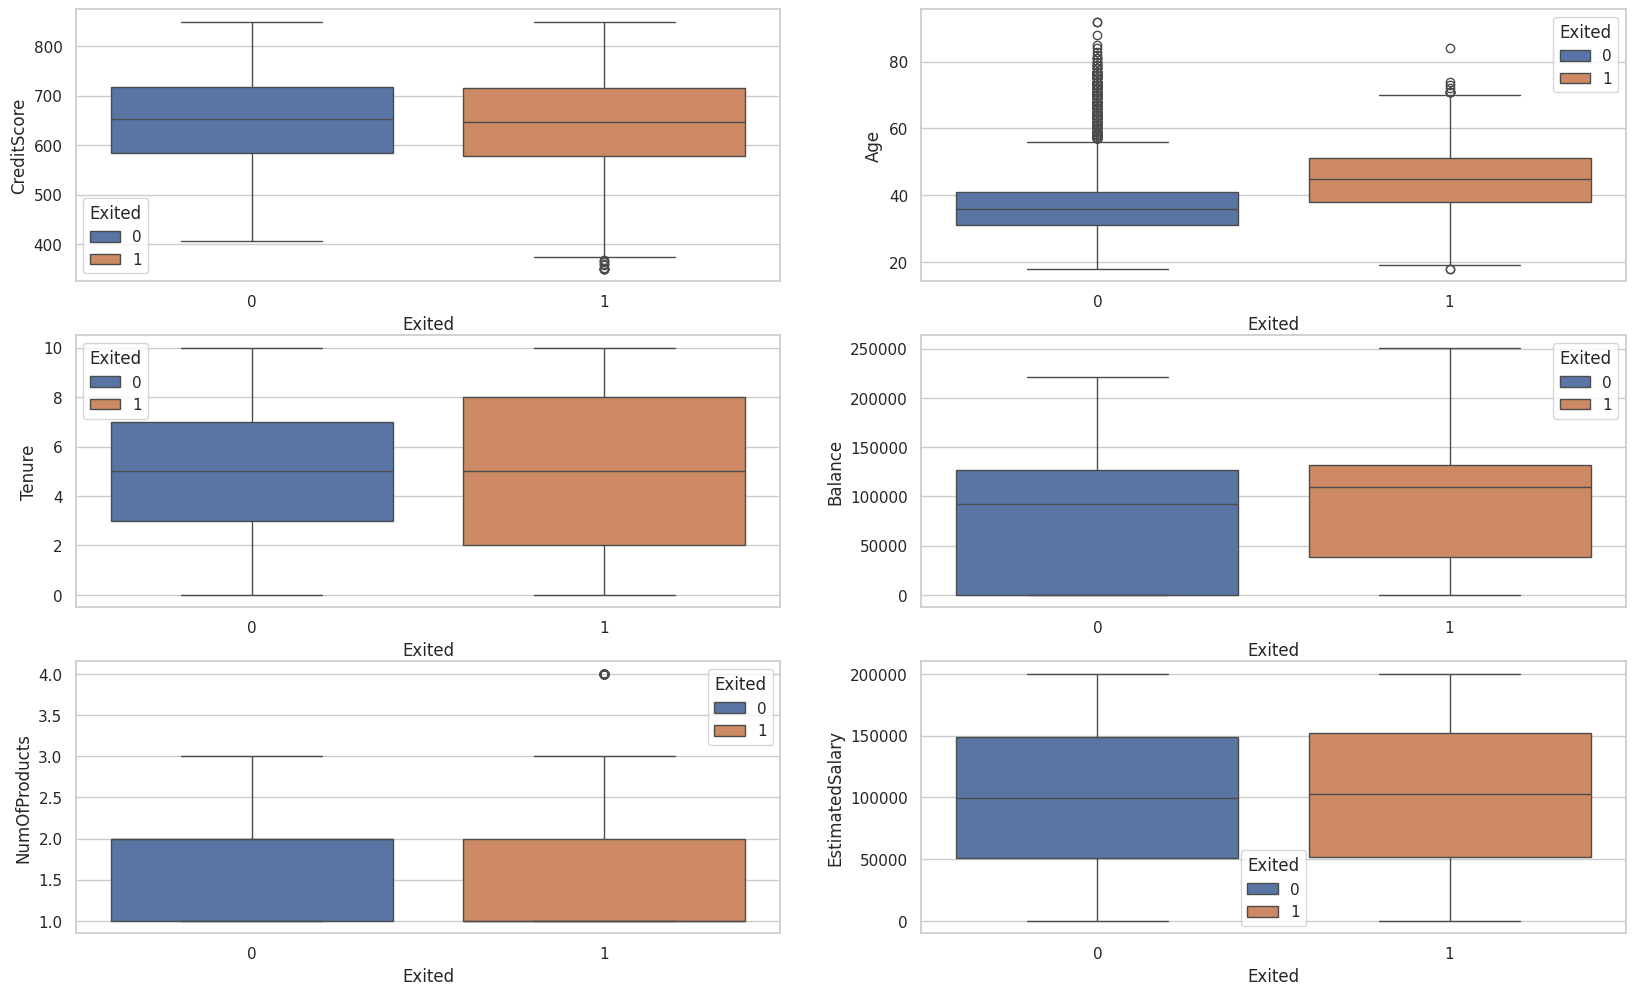

In [13]:
# Relations based on the continuous data attributes
fig, axarr = plt.subplots(3, 2, figsize=(20, 12))
sns.boxplot(y='CreditScore',x = 'Exited', hue = 'Exited',data = df, ax=axarr[0][0])
sns.boxplot(y='Age',x = 'Exited', hue = 'Exited',data = df , ax=axarr[0][1])
sns.boxplot(y='Tenure',x = 'Exited', hue = 'Exited',data = df, ax=axarr[1][0])
sns.boxplot(y='Balance',x = 'Exited', hue = 'Exited',data = df, ax=axarr[1][1])
sns.boxplot(y='NumOfProducts',x = 'Exited', hue = 'Exited',data = df, ax=axarr[2][0])
sns.boxplot(y='EstimatedSalary',x = 'Exited', hue = 'Exited',data = df, ax=axarr[2][1])

# **Rebalanceando o banco de dados**

In [14]:
cat_vars = ['Geography', 'Gender', 'HasCrCard', 'IsActiveMember']
df = pd.get_dummies(df, columns=cat_vars, drop_first=False)

In [15]:
df_final = df.copy()

In [16]:
X = df_final.drop(columns='Exited')
y = df_final['Exited']
from imblearn.over_sampling import SMOTE
os = SMOTE(random_state=0)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)
columns = X_train.columns
os_df_X,os_df_y=os.fit_resample(X_train, y_train)
os_df_X = pd.DataFrame(os_df_X,columns=columns )
os_df_y= pd.DataFrame(os_df_y,columns=['Exited'])
# we can Check the numbers of our data
print("Tamanho do oversampled é: ",len(os_df_X))
print("Contagem de classes no oversampled data:")
print(os_df_y['Exited'].value_counts())
print("Proporção de clientes retidos: {:.2f}%".format(os_df_y['Exited'].value_counts(normalize=True)[0] * 100))
print("Proporção de clientes que saíram: {:.2f}%".format(os_df_y['Exited'].value_counts(normalize=True)[1] * 100))

Tamanho do oversampled é:  11168
Contagem de classes no oversampled data:
Exited
1    5584
0    5584
Name: count, dtype: int64
Proporção de clientes retidos: 50.00%
Proporção de clientes que saíram: 50.00%


/tmp/ipython-input-17-3876985585.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='Exited', data=os_df_y, palette='pastel')


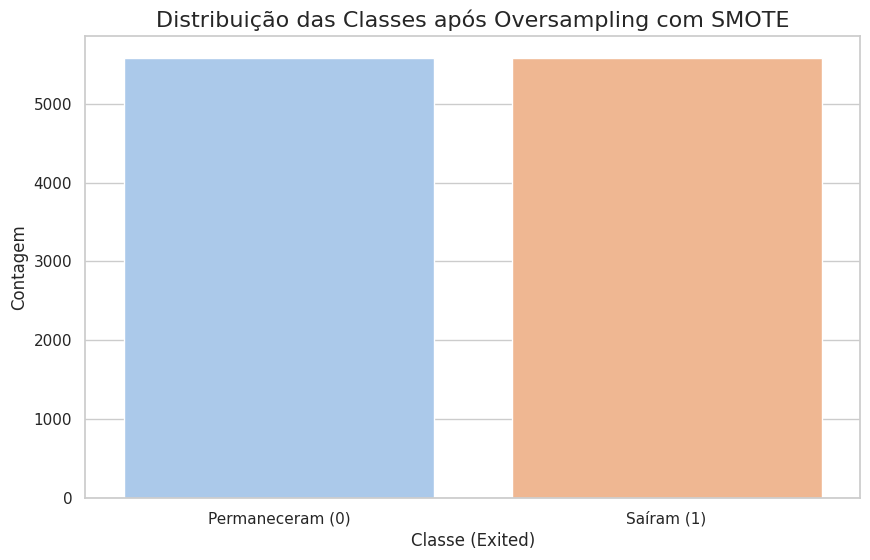

In [17]:
plt.figure(figsize=(10,6))
sns.countplot(x='Exited', data=os_df_y, palette='pastel')
plt.title('Distribuição das Classes após Oversampling com SMOTE', fontsize=16)
plt.xlabel('Classe (Exited)', fontsize=12)
plt.ylabel('Contagem', fontsize=12)
plt.xticks([0,1], ['Permaneceram (0)', 'Saíram (1)'])
plt.show()

In [18]:
# RFE - Para seleção de variáveis

import statsmodels.api as sm
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression


model = LogisticRegression(solver='liblinear', max_iter=1000)
rfe = RFE(estimator=model, n_features_to_select=15)
rfe.fit(X_train, y_train.values.ravel()) # Use X_train and y_train from the split
variaveis_selecionadas = X.columns[rfe.support_].tolist()

print("Variáveis selecionadas:", variaveis_selecionadas)

Variáveis selecionadas: ['CreditScore', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'EstimatedSalary', 'Geography_France', 'Geography_Germany', 'Geography_Spain', 'Gender_Female', 'Gender_Male', 'HasCrCard_0', 'HasCrCard_1', 'IsActiveMember_0', 'IsActiveMember_1']


In [19]:
import statsmodels.api as sm


# 1. Selecionar variáveis escolhidas pelo RFE
x = os_df_X[variaveis_selecionadas].copy()
y = os_df_y['Exited'].copy()

# 2. Converter booleanos para inteiros (essencial para o statsmodels)
x = x.astype(int)

# 3. Garantir que y é numérico
y = pd.to_numeric(y, errors='coerce')

# 4. Remover linhas com possíveis valores ausentes (por segurança)
mask = x.notnull().all(axis=1) & y.notnull()
x = x.loc[mask]
y = y.loc[mask]

# 5. Adicionar constante
x_const = sm.add_constant(x)

# 6. Ajustar modelo Logit
logit_model = sm.Logit(y, x_const)
result = logit_model.fit(disp=True)

# 7. Exibir resumo
print(result.summary2())

         Current function value: 0.300705
         Iterations: 35
                               Results: Logit
Model:                   Logit                Method:               MLE      
Dependent Variable:      Exited               Pseudo R-squared:     0.566    
Date:                    2025-07-19 01:22     AIC:                  6748.5522
No. Observations:        11168                BIC:                  6865.6851
Df Model:                15                   Log-Likelihood:       -3358.3  
Df Residuals:            11152                LL-Null:              -7741.1  
Converged:               0.0000               LLR p-value:          0.0000   
No. Iterations:          35.0000              Scale:                1.0000   
-----------------------------------------------------------------------------
                   Coef.    Std.Err.     z    P>|z|     [0.025       0.975]  
-----------------------------------------------------------------------------
const             -99.6568 963

/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


O modelo apresenta pseudo R² de 0.566, sugerindo ajuste razoável. Variáveis como Age, Balance, Geography_Germany e IsActiveMember_1 são estatisticamente significativas (p < 0.05), indicando forte associação com a saída do cliente. O aviso de não convergência indica que os resultados podem ser instáveis, sendo recomendada uma nova tentativa com ajustes no modelo.

In [20]:
log_odds = result.params
pd.DataFrame({'coef': log_odds})\
            .sort_values(by='coef', ascending=False)

,coef
Gender_Female,2.980721e+01
Gender_Male,2.925150e+01
IsActiveMember_0,2.537298e+01
IsActiveMember_1,2.433505e+01
Geography_Germany,2.280096e+01
Geography_France,2.189899e+01
Geography_Spain,2.187943e+01
HasCrCard_1,2.013750e+01
HasCrCard_0,2.006008e+01
Age,7.205057e-02


In [21]:
# Calcula os odds ratios com base nos coeficientes do modelo
odds = np.exp(result.params)

# Cria DataFrame com os odds e ordena
odds_df = pd.DataFrame(odds, columns=['coef']).sort_values(by='coef', ascending=False)

# Exibe a tabela formatada
print(odds_df)

                           coef
Gender_Female      8.812621e+12
Gender_Male        5.055530e+12
IsActiveMember_0   1.045550e+11
IsActiveMember_1   3.703224e+10
Geography_Germany  7.986055e+09
Geography_France   3.240497e+09
Geography_Spain    3.177710e+09
HasCrCard_1        5.566802e+08
HasCrCard_0        5.152065e+08
Age                1.074710e+00
Balance            1.000001e+00
EstimatedSalary    1.000000e+00
CreditScore        9.990243e-01
Tenure             9.660152e-01
NumOfProducts      7.070039e-01
const              5.243017e-44


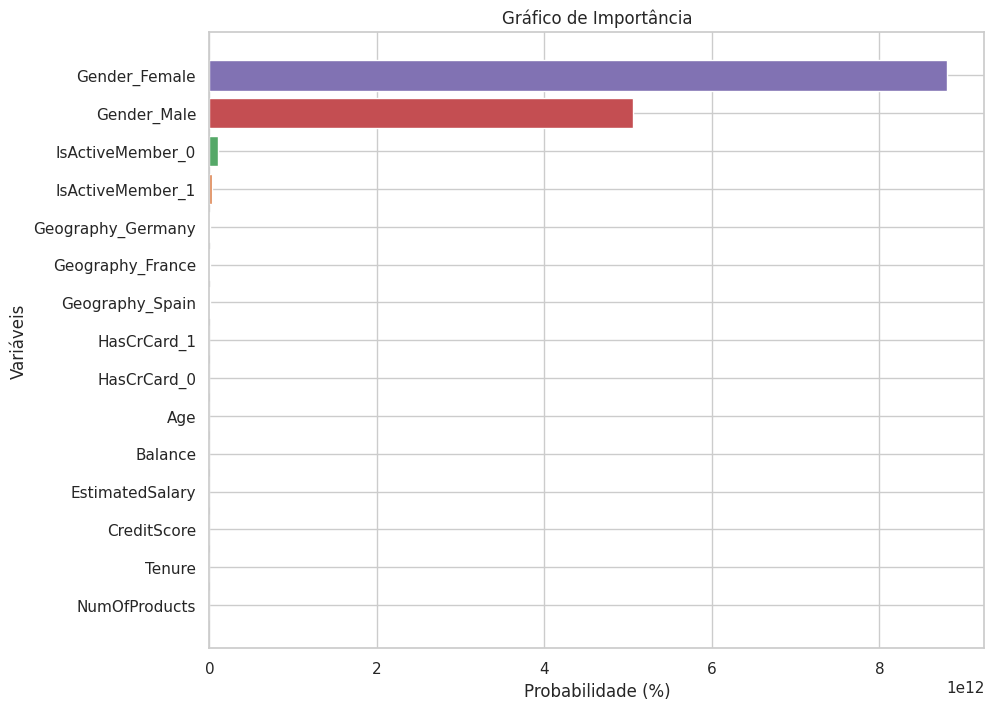

In [22]:
# Gráfico de importância

coefficients = pd.DataFrame(odds, X.columns, columns=['coef']).sort_values(by='coef', ascending=True)

plt.figure(figsize=(10,8))
plt.barh(coefficients.index, coefficients['coef'], color=['C{}'.format(i) for i in range(len(coefficients))])
plt.xlabel('Probabilidade (%)')
plt.ylabel('Variáveis')
plt.title('Gráfico de Importância')
plt.show()

# **Avaliação da Previsibilidade do Modelo**

In [23]:
# Previsão no conjunto de teste
y_pred_prob = result.predict(sm.add_constant(X_test[variaveis_selecionadas].astype(int)))

# Converte probabilidade em classe (limiar padrão = 0.5)
y_pred = (y_pred_prob >= 0.5).astype(int)

In [24]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

print("Acurácia: {:.2f}".format(accuracy_score(y_test, y_pred)))
print("Precisão: {:.2f}".format(precision_score(y_test, y_pred)))
print("Revocação (Recall): {:.2f}".format(recall_score(y_test, y_pred)))
print("F1-Score: {:.2f}".format(f1_score(y_test, y_pred)))

Acurácia: 0.81
Precisão: 0.57
Revocação (Recall): 0.29
F1-Score: 0.39


**Conclusão das métricas acima:**

Os resultados indicam que o modelo apresenta uma acurácia de 81%, o que sugere um desempenho aparentemente satisfatório no geral. Contudo, devido ao desbalanceamento da base de dados, em que apenas cerca de 20% dos clientes efetuam churn, essa métrica pode ser enganosa. A precisão, que mede a proporção de acertos entre as previsões positivas, é de 57%, indicando que quase metade das predições de churn são falsas. O recall, que avalia a capacidade do modelo de identificar efetivamente os clientes que saem, está em apenas 29%, revelando uma baixa sensibilidade e grande quantidade de churns não detectados. O F1-Score, que sintetiza precisão e recall, confirma essa limitação, apresentando valor baixo (39%). Em resumo, apesar da boa acurácia, o modelo demonstra desempenho insuficiente para detectar churn, possivelmente devido à predominância da classe majoritária, exigindo abordagens que aumentem sua sensibilidade em bases desbalanceadas.

# **Matriz de confusão**

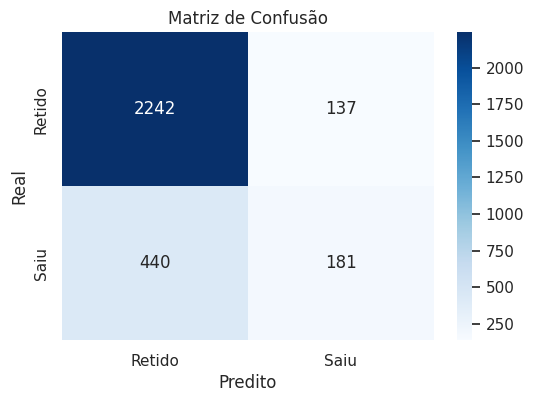

In [25]:
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=['Retido', 'Saiu'], yticklabels=['Retido', 'Saiu'])
plt.xlabel('Predito')
plt.ylabel('Real')
plt.title('Matriz de Confusão')
plt.show()

**Conclusão da Matriz de confusão:**

A matriz de confusão indica que o modelo possui alta acurácia na identificação de clientes que permaneceram, com 2242 verdadeiros negativos. No entanto, seu desempenho em prever corretamente os clientes que saem é limitado, evidenciado por 181 verdadeiros positivos e 440 falsos negativos — ou seja, a maioria dos clientes que efetivamente deixaram o banco não foi identificada pelo modelo. Além disso, houve 137 falsos positivos, ou seja, clientes retidos que foram incorretamente previstos como churn. O principal desafio do modelo, portanto, está na sua baixa sensibilidade para detectar a classe minoritária (churn), sendo necessária uma otimização que melhore essa capacidade preditiva.

# **Curva ROC e AUC**

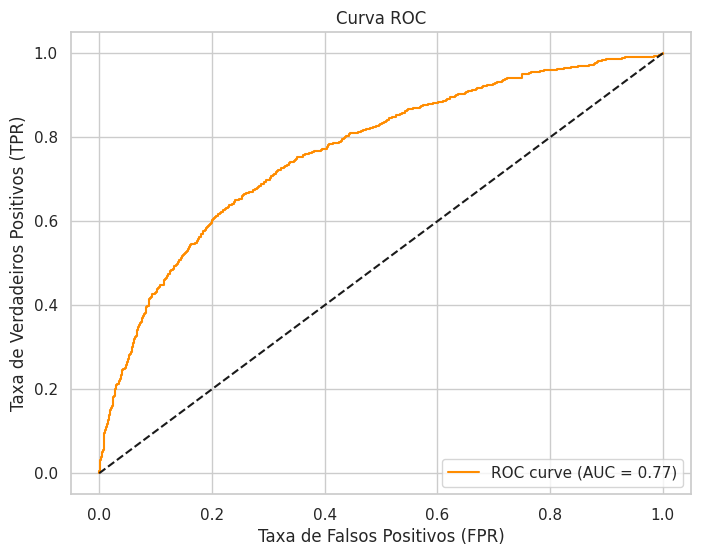

In [26]:
from sklearn.metrics import roc_curve, roc_auc_score

fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)
roc_auc = roc_auc_score(y_test, y_pred_prob)

plt.figure(figsize=(8,6))
plt.plot(fpr, tpr, label=f'ROC curve (AUC = {roc_auc:.2f})', color='darkorange')
plt.plot([0, 1], [0, 1], 'k--')  # Linha diagonal
plt.xlabel('Taxa de Falsos Positivos (FPR)')
plt.ylabel('Taxa de Verdadeiros Positivos (TPR)')
plt.title('Curva ROC')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

**Conclusão da Curva ROC**

A Curva ROC apresentada, com uma Área Sob a Curva (AUC) de 0.77, indica que o modelo possui uma capacidade discriminatória moderada a boa. A curva laranja se afasta da linha pontilhada diagonal, que representa um classificador aleatório, evidenciando que o modelo tem desempenho preditivo superior ao acaso. Embora o AUC de 0.77 esteja abaixo de valores ideais (próximos de 1.0), ele demonstra que o modelo consegue distinguir, com certa eficácia, entre clientes que permanecem e os que saem. Ainda assim, há espaço para melhorias, especialmente no equilíbrio entre a taxa de verdadeiros positivos e a de falsos positivos, com o objetivo de aumentar a performance global do modelo.